In [1]:
#%load_ext autoreload
#%autoreload 2

In [ ]:
import glob
import numpy as np
import pandas as pd
import pyranges as pr
import scipy
import seaborn as sns
import tqdm
import anndata as ad
import plotnine as p9

from borzoi_pytorch import Borzoi as Borzoi

import pyranges as pr

import scanpy as sc
import pandas as pd
import numpy as np

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_size_factor_key_expr' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_size_factor_key_acc' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


# Susie

## Prepare dataframe

In [3]:
data_path = '/data/ceph/hdd/project/node_08/QNA/scborzoi/submission_data/'
gtf_file = f"{data_path}gencode.v32.annotation.sorted.gtf.gz"
gtf = pr.read_gtf(gtf_file).df.query('Feature == "gene"')
gtf['gene_id'] = gtf['gene_id'].apply(lambda x: x.split('.')[0])
gtf = gtf[['Start','End','Strand','gene_name','gene_id']].rename(columns={'Start':'gene_start','End':'gene_end'}).drop_duplicates(subset=['gene_id','gene_name'])

In [5]:
susie_df = pd.read_table(f'{data_path}eQTL_fig4/all_highpip_susie.tsv')

In [6]:
susie_len = len(susie_df)
susie_df = susie_df.merge(gtf, on=['gene_id','gene_name'])
assert len(susie_df) == susie_len

In [7]:
susie_df['dist_to_tss'] = (susie_df['Pos'] - susie_df['gene_start'])*(susie_df['Strand'] == "+") + (susie_df['Pos'] - susie_df['gene_end'])*(susie_df['Strand'] == "-")
susie_df['abs_dist_to_tss'] = np.abs(susie_df['dist_to_tss'])

In [8]:
susie_df['unique_id'] = susie_df['variant'] + "_" + susie_df['gene_id']

In [9]:
def make_borzoi_mapping(adata):
    mapping = {}
    mapping['BLUEPRINT'] = {
         'monocyte':list(adata.var.loc[adata.var.description.str.contains('monocyte',case=False)]['description']),
         'CD4+ T cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25'))]['description']),
    }
    mapping['CAP'] = {
         'LCL':list(adata.var.loc[adata.var.description.str.contains('B cell',case=False)]['description']),
    }
    mapping['GENCORD'] = {
         'LCL':list(adata.var.loc[adata.var.description.str.contains('B cell',case=False)]['description']),
         'T cell':list(adata.var.loc[adata.var.description.str.contains('T cell')]['description']),
    }
    mapping['GEUVADIS'] = {
         'LCL':list(adata.var.loc[adata.var.description.str.contains('B cell',case=False)]['description']),
    }
    mapping['Lepik_2017'] = {
         'blood':['RNA:blood'],
    }
    mapping['Nathan_2022'] = {
         'CD4+ T cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25'))]['description']),
    }
    mapping['Randolph_2021'] = {
         'CD4+ T cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25'))]['description']),
    }
    mapping['Quach_2016'] = {
         'monocyte':list(adata.var.loc[adata.var.description.str.contains('monocyte',case=False)]['description']),
    }
    mapping['Schmiedel_2018'] = {
         'CD4+ T cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25'))]['description']),
         'CD8+ T cell':list(adata.var.loc[adata.var.description.str.contains('CD8')]['description']),
         'monocyte':list(adata.var.loc[adata.var.description.str.contains('monocyte',case=False)]['description']),
         'CD16+ monocyte':list(adata.var.loc[adata.var.description.str.contains('monocyte',case=False)]['description']),
         'NK cell':list(adata.var.loc[adata.var.description.str.contains('natural',case=False)]['description']),
         'B cell':list(adata.var.loc[adata.var.description.str.contains('B cell',case=False)]['description']),
    }
    mapping['TwinsUK'] = {
        'LCL':list(adata.var.loc[adata.var.description.str.contains('B cell',case=False)]['description']),
        'blood':['RNA:blood'],
    }
    mapping['OneK1K'] = {
         'B cell':list(adata.var.loc[adata.var.description.str.contains('B cell',case=False) & ~(adata.var.description.str.contains('memory',case=False))]['description']),
         'CD4+ T cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25'))]['description']),
         'CD4+ TCM cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25')) & adata.var.description.str.contains('memory')]['description']),
         'CD4+ TEM cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25')) & adata.var.description.str.contains('memory')]['description']),
         'CD4+ CTL cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & adata.var.description.str.contains('activated|stimulated') & (~adata.var.description.str.contains('memory'))]['description']),
         'CD8+ T cell':list(adata.var.loc[adata.var.description.str.contains('CD8')]['description']),
         'CD8+ TCM cell':list(adata.var.loc[adata.var.description.str.contains('CD8') & adata.var.description.str.contains('memory')]['description']),
         'CD8+ TEM cell':list(adata.var.loc[adata.var.description.str.contains('CD8') & adata.var.description.str.contains('memory')]['description']),
         'NK cell':list(adata.var.loc[adata.var.description.str.contains('natural',case=False)]['description']),
         'CD56+ NK cell':list(adata.var.loc[adata.var.description.str.contains('natural',case=False)]['description']),
         'hematopoietic precursor cell':list(adata.var.loc[adata.var.description.str.contains('hemato',case=False)]['description']),
         'memory B cell':list(adata.var.loc[adata.var.description.str.contains('B cell',case=False) & (adata.var.description.str.contains('memory',case=False))]['description']),
         'monocyte':list(adata.var.loc[adata.var.description.str.contains('monocyte',case=False)]['description']),
         'CD16+ monocyte':list(adata.var.loc[adata.var.description.str.contains('monocyte',case=False)]['description']),
         'Treg memory':list(adata.var.loc[adata.var.description.str.contains('CD25',case=False)]['description']),
         'dendritic cell' : list(adata.var.loc[adata.var.description.str.contains('monocyte',case=False)]['description']), #not in borzoi RNA
         #'plasmacytoid dendritic cell', #not in borzoi RNA
    }
    mapping['GTEx'] = {
         'LCL':list(adata.var.loc[adata.var.description.str.contains('B cell',case=False)]['description']),
         'blood':['RNA:blood'],
    }
    return mapping

In [11]:
rows = []
df_list = []
rna_mapping = None
cage_mapping = None
for assay_type in ['RNA']:
    for model in ['borzoi_bs1_highpip']:
        for rep in [0]:
            adata_list = []
            autocast = ""
            assay_path = 'tsscentred'
            paths = sorted(glob.glob(f'{data_path}/eQTL_fig4/{model}_tsscentred_keepscale_{autocast}{rep}/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
            for path in paths:
                adata = ad.read_h5ad(path)
                if rna_mapping is None and assay_type == 'RNA':
                    rna_mapping = make_borzoi_mapping(adata)
                    borzoi_mapping = rna_mapping
                mapping = rna_mapping if assay_type == 'RNA' else cage_mapping
                adata_list.append(adata)
            
            adata = ad.concat(adata_list, merge='same')
            adata.obs_names = adata.obs['variant'] + "_" + adata.obs['gene_id']
            
            for study in mapping.keys():
                tissue_mapping = mapping[study]
                for tissue in tissue_mapping.keys():
                    reduced_susie = susie_df.query('study_label == @study and tissue_label == @tissue').sort_values('sample_size',ascending=False).drop_duplicates(subset=['gene_id','variant'], keep='first')
                
                    reduced_adata = adata[adata.obs.index.isin(set(reduced_susie['unique_id'])), adata.var.description.isin(tissue_mapping[tissue])]
                    snp_effects = pd.DataFrame({'variant':reduced_adata.obs['variant'],
                                                'gene_id':reduced_adata.obs['gene_id'],
                                                'pred_effect':reduced_adata.X.mean(axis=1)})
                    snp_effects['abs_pred_effect'] = np.abs(snp_effects['pred_effect'])
                    
                    reduced_susie = reduced_susie.merge(snp_effects, on=['variant','gene_id'])
                    assert len(reduced_susie) == len(snp_effects)
        
                    corr = scipy.stats.spearmanr(reduced_susie['beta'],reduced_susie['pred_effect'])[0]
                    pearson = scipy.stats.pearsonr(reduced_susie['beta'],reduced_susie['pred_effect'])[0]
                    dist_corr = scipy.stats.spearmanr(reduced_susie['abs_dist_to_tss'],reduced_susie['abs_pred_effect'])[0]
                    rows.append({'model':model, 'study':study, 'tissue':tissue, 'n':len(snp_effects),
                                 'rep':rep, 'corr':corr, 'r':pearson, 'dist_corr':dist_corr, 'assay_type':assay_type})
        
                    reduced_susie['model'] = model
                    reduced_susie['rep'] = rep
                    reduced_susie['assay_type'] = assay_type
                    df_list.append(reduced_susie)

all_corrs = pd.DataFrame(rows)
all_vars = pd.concat(df_list)

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [12]:
borzoi_corrs = all_corrs.query('study =="OneK1K" or (study == "GTEx" and tissue == "blood")')
borzoi_corrs

,model,study,tissue,n,rep,corr,r,dist_corr,assay_type
18,borzoi_bs1_highpip,OneK1K,B cell,62,0,0.248017,0.281106,-0.555035,RNA
19,borzoi_bs1_highpip,OneK1K,CD4+ T cell,268,0,0.349318,0.292655,-0.535780,RNA
20,borzoi_bs1_highpip,OneK1K,CD4+ TCM cell,391,0,0.377777,0.319417,-0.541103,RNA
21,borzoi_bs1_highpip,OneK1K,CD4+ TEM cell,22,0,-0.034444,-0.105141,-0.451158,RNA
22,borzoi_bs1_highpip,OneK1K,CD4+ CTL cell,7,0,0.071429,0.129588,0.357143,RNA
23,borzoi_bs1_highpip,OneK1K,CD8+ T cell,42,0,0.199903,0.213096,-0.437971,RNA
24,borzoi_bs1_highpip,OneK1K,CD8+ TCM cell,10,0,-0.381818,-0.388129,-0.660606,RNA
25,borzoi_bs1_highpip,OneK1K,CD8+ TEM cell,146,0,0.252986,0.227036,-0.559038,RNA
26,borzoi_bs1_highpip,OneK1K,NK cell,230,0,0.328797,0.241144,-0.534944,RNA
27,borzoi_bs1_highpip,OneK1K,CD56+ NK cell,5,0,-0.400000,-0.927365,-0.100000,RNA


## Scooby, pseudobulk variants

In [13]:
model = 'scooby_neurips'
adata_list = []

paths = sorted(glob.glob(f'{data_path}/eQTL_fig4/scooby_variants_tsscentred/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
for path in tqdm.tqdm(paths):
    adata = ad.read_h5ad(path)
    adata_list.append(adata)

100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


In [14]:
adata = ad.concat(adata_list, merge='same')
adata.obs_names = adata.obs['variant'] + "_" + adata.obs['gene_id']

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [15]:
adata.var_names

Index(['B_cell', 'CD16+_monocyte', 'CD4+_CTL_cell', 'CD4+_TCM_cell',
       'CD4+_TEM_cell', 'CD4+_T_cell', 'CD56+_NK_cell', 'CD8+_TCM_cell',
       'CD8+_TEM_cell', 'CD8+_T_cell', 'MAIT_cell', 'NK_cell', 'Treg_memory',
       'dendritic_cell', 'dnT_cell', 'gdT_cell',
       'hematopoietic_precursor_cell', 'memory_B_cell', 'monocyte',
       'plasmablast', 'plasmacytoid_dendritic_cell', 'platelet'],
      dtype='object', name='celltype')

In [16]:
def make_scooby_mapping(adata):
    mapping = dict()
    mapping['GTEx'] = {
        'blood' : set(susie_df.query('study_label == "OneK1K"').tissue_label.str.replace(' ', '_')),
    }
    mapping['OneK1K'] = dict()
    for ct in set(susie_df.query('study_label == "OneK1K"').tissue_label.unique()):
        mapping['OneK1K'][ct] = [ct.replace(" ", "_")]
    
    return mapping
    
mapping = make_scooby_mapping(adata)
rows = []
for study in mapping.keys():
    tissue_mapping = mapping[study]
    for tissue in tissue_mapping.keys():
        reduced_susie = susie_df.query('study_label == @study and tissue_label == @tissue').sort_values('sample_size',ascending=False).drop_duplicates(subset=['gene_id','variant'], keep='first')
        assert len(reduced_susie) > 0
        reduced_adata = adata[adata.obs.index.isin(set(reduced_susie['unique_id'])), adata.var.index.isin(tissue_mapping[tissue])]
        snp_effects = pd.DataFrame({'variant':reduced_adata.obs['variant'],
                                    'gene_id':reduced_adata.obs['gene_id'],
                                    'pred_effect':reduced_adata.X.mean(axis=1)})
        snp_effects['abs_pred_effect'] = np.abs(snp_effects['pred_effect'])
        
        reduced_susie = reduced_susie.merge(snp_effects, on=['variant','gene_id'])
        assert len(reduced_susie) == len(snp_effects)
    
        corr = scipy.stats.spearmanr(reduced_susie['beta'],reduced_susie['pred_effect'])[0]
        dist_corr = scipy.stats.spearmanr(reduced_susie['abs_dist_to_tss'],reduced_susie['abs_pred_effect'])[0]
        rows.append({'model':model, 'study':study, 'tissue':tissue, 'n':len(snp_effects),
                     'corr':corr, 'dist_corr':dist_corr})
all_corrs_scooby = pd.DataFrame(rows)

In [17]:
adata_ct = adata.copy()

In [20]:
scooby_corrs = all_corrs_scooby.sort_values('corr')

In [21]:
corrs_compare = borzoi_corrs.merge(scooby_corrs, on  =['study', 'tissue'], suffixes =['_borzoi', '_scooby'])

In [22]:
corrs_compare = corrs_compare.replace('GTEx', 'GTEx, whole blood')

In [23]:
corrs_compare = corrs_compare.rename({"study" : "Study"}, axis = 1)

In [24]:
corrs_compare

,model_borzoi,Study,tissue,n_borzoi,rep,corr_borzoi,r,dist_corr_borzoi,assay_type,model_scooby,n_scooby,corr_scooby,dist_corr_scooby
0,borzoi_bs1_highpip,OneK1K,B cell,62,0,0.248017,0.281106,-0.555035,RNA,scooby_neurips,62,0.467402,-0.541387
1,borzoi_bs1_highpip,OneK1K,CD4+ T cell,268,0,0.349318,0.292655,-0.535780,RNA,scooby_neurips,268,0.365821,-0.486432
2,borzoi_bs1_highpip,OneK1K,CD4+ TCM cell,391,0,0.377777,0.319417,-0.541103,RNA,scooby_neurips,391,0.395630,-0.486724
3,borzoi_bs1_highpip,OneK1K,CD4+ TEM cell,22,0,-0.034444,-0.105141,-0.451158,RNA,scooby_neurips,22,0.033315,-0.480519
4,borzoi_bs1_highpip,OneK1K,CD4+ CTL cell,7,0,0.071429,0.129588,0.357143,RNA,scooby_neurips,7,0.500000,-0.107143
5,borzoi_bs1_highpip,OneK1K,CD8+ T cell,42,0,0.199903,0.213096,-0.437971,RNA,scooby_neurips,42,0.270724,-0.286606
6,borzoi_bs1_highpip,OneK1K,CD8+ TCM cell,10,0,-0.381818,-0.388129,-0.660606,RNA,scooby_neurips,10,0.236364,-0.587879
7,borzoi_bs1_highpip,OneK1K,CD8+ TEM cell,146,0,0.252986,0.227036,-0.559038,RNA,scooby_neurips,146,0.410190,-0.481253
8,borzoi_bs1_highpip,OneK1K,NK cell,230,0,0.328797,0.241144,-0.534944,RNA,scooby_neurips,230,0.430627,-0.542012
9,borzoi_bs1_highpip,OneK1K,CD56+ NK cell,5,0,-0.400000,-0.927365,-0.100000,RNA,scooby_neurips,5,-0.100000,0.300000


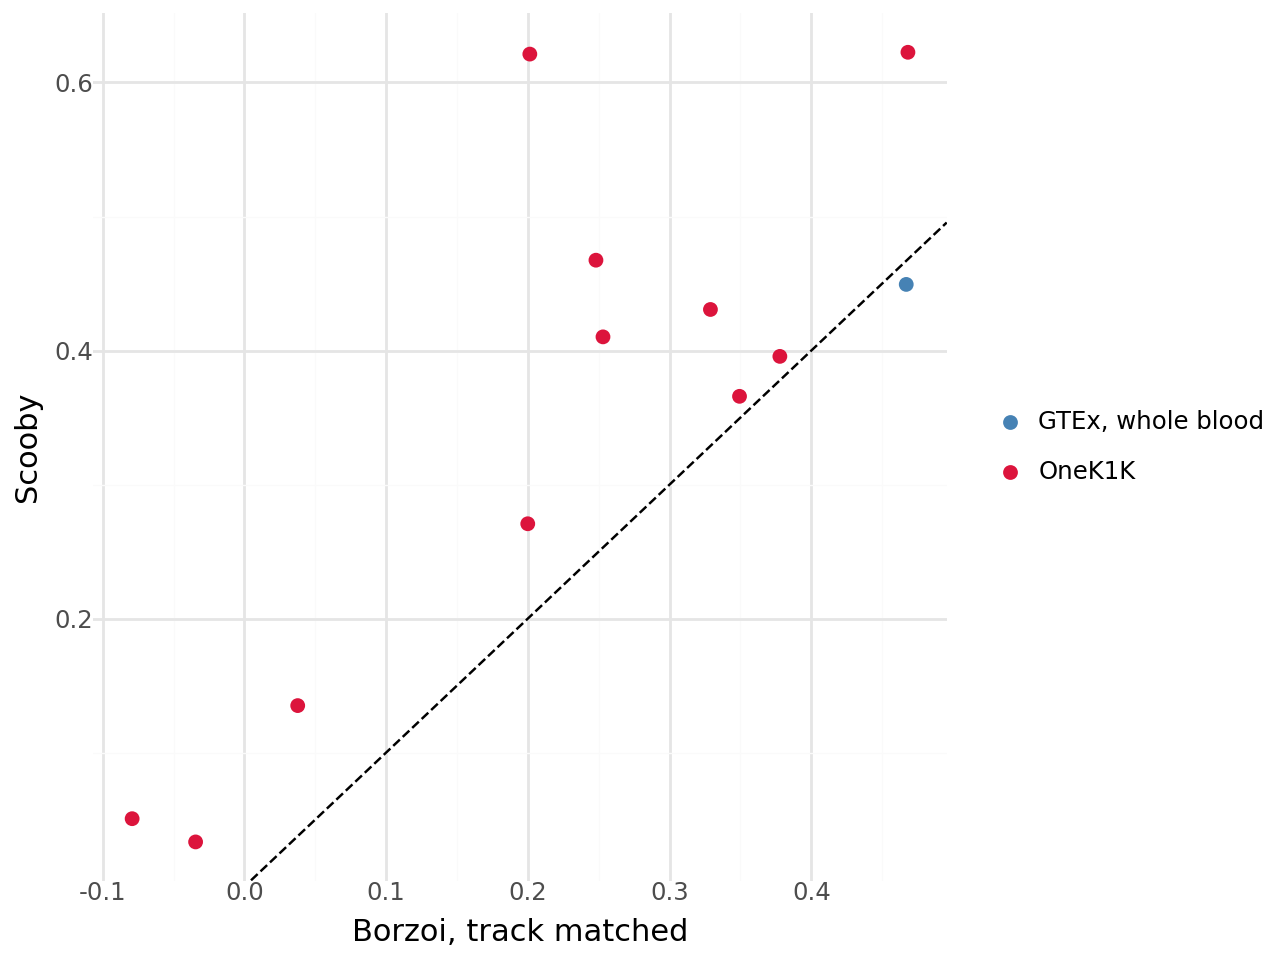

In [25]:
import plotnine as p9
p =(p9.ggplot(data=corrs_compare.query("n_borzoi>10"), mapping=p9.aes(x='corr_borzoi',y='corr_scooby', color='Study')) 
 + p9.geom_point(size=2) 
 + p9.geom_abline(linetype='dashed')
 + p9.theme_minimal()
 + p9.scale_color_manual(['steelblue', 'crimson'])
 + p9.labs(x='Borzoi, track matched', y='Scooby')
 + p9.theme(legend_title=p9.element_blank())
)
# p.save("../../figures/figures/Revisions/scooby_borzoi_eqtl_perf.png", dpi = 300)
p

In [26]:
scipy.stats.wilcoxon(corrs_compare.query("n_borzoi>10")['corr_scooby'], corrs_compare.query("n_borzoi>10")['corr_borzoi'])

WilcoxonResult(statistic=2.0, pvalue=0.00146484375)

## Scooby, vs seq2cells

In [75]:
model = 'scooby_neurips'
adata_list = []

paths = sorted(glob.glob(f'{data_path}/eQTL_preds/Results/Susie/Chunky/scooby_variants_tsscentred/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
for path in tqdm.tqdm(paths):
    adata = ad.read_h5ad(path)
    adata_list.append(adata)

100%|██████████| 11/11 [00:01<00:00,  7.98it/s]


In [76]:
adata = ad.concat(adata_list, merge='same')
adata.obs_names = adata.obs['variant'] + "_" + adata.obs['gene_id']

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [77]:
seq2cells_onek1k = pd.read_csv("seq2cells_onek1k.csv")
seq2cells_gtex = pd.read_csv("seq2cells_gtex.csv")
seq2cells = pd.concat([seq2cells_onek1k, seq2cells_gtex])

In [78]:
def make_scooby_mapping(adata):
    mapping = dict()
    mapping['GTEx'] = {
        'blood' : set(susie_df.query('study_label == "OneK1K"').tissue_label.str.replace(' ', '_')),
    }    
    mapping['OneK1K'] = dict()
    for ct in set(susie_df.query('study_label == "OneK1K"').tissue_label.unique()):
        mapping['OneK1K'][ct] = [ct.replace(" ", "_")]
    return mapping
    
mapping = make_scooby_mapping(adata)
rows = []
for study in mapping.keys():
    tissue_mapping = mapping[study]
    for tissue in tissue_mapping.keys():
        reduced_susie = susie_df.query('study_label == @study and tissue_label == @tissue').sort_values('sample_size',ascending=False).drop_duplicates(subset=['gene_id','variant'], keep='first').merge(seq2cells, right_on = ['var_id', 'var_linked_gene', 'study_label', 'tissue_label'], left_on = ['variant', 'gene_id','study_label', 'tissue_label'], suffixes=['', '_seq2cells']).drop_duplicates(subset=['gene_id','variant'], keep='first')
        assert len(reduced_susie) > 0
        reduced_adata = adata[adata.obs.index.isin(set(reduced_susie['unique_id'])), adata.var.index.isin(tissue_mapping[tissue])]
        snp_effects = pd.DataFrame({'variant':reduced_adata.obs['variant'],
                                    'gene_id':reduced_adata.obs['gene_id'],
                                    'pred_effect':reduced_adata.X.mean(axis=1)})
        snp_effects['abs_pred_effect'] = np.abs(snp_effects['pred_effect'])
        
        reduced_susie = reduced_susie.merge(snp_effects, on=['variant','gene_id'])
        assert len(reduced_susie) == len(snp_effects)
    
        corr = scipy.stats.spearmanr(reduced_susie['beta'],reduced_susie['pred_effect'])[0]
        corr_seq2cells = scipy.stats.spearmanr(reduced_susie['beta'],reduced_susie['pred_beta'])[0]
        dist_corr = scipy.stats.spearmanr(reduced_susie['abs_dist_to_tss'],reduced_susie['abs_pred_effect'])[0]
        rows.append({'model':model, 'study':study, 'tissue':tissue, 'n':len(snp_effects),
                     'corr':corr, 'dist_corr':dist_corr})
        rows.append({'model':"seq2cells", 'study':study, 'tissue':tissue, 'n':len(snp_effects),
                     'corr':corr_seq2cells})
all_corrs_scooby = pd.DataFrame(rows)

In [79]:
all_corrs_scooby.head()

,model,study,tissue,n,corr,dist_corr
0,scooby_neurips,GTEx,blood,618,0.474967,-0.487533
1,seq2cells,GTEx,blood,618,0.351031,NaN
2,scooby_neurips,OneK1K,CD8+ T cell,32,0.320381,-0.121701
3,seq2cells,OneK1K,CD8+ T cell,32,-0.099340,NaN
4,scooby_neurips,OneK1K,CD8+ TCM cell,7,0.750000,-0.464286


In [80]:
adata_ct = adata.copy()

In [81]:
all_corrs_scooby = all_corrs_scooby.replace('GTEx', 'GTEx, whole blood')

In [82]:
all_corrs_scooby = all_corrs_scooby.rename({"study" : "Study"}, axis = 1)

In [83]:
all_corrs_scooby = all_corrs_scooby.query("n>10").pivot(columns=['model'], values='corr', index=['Study', 'tissue'])

In [84]:
all_corrs_scooby.head()

model                             scooby_neurips  seq2cells
Study             tissue                                   
GTEx, whole blood blood                 0.474967   0.351031
OneK1K            B cell                0.552220   0.197322
                  CD16+ monocyte        0.814286   0.478571
                  CD4+ T cell           0.399487   0.227584
                  CD4+ TCM cell         0.463709   0.283532

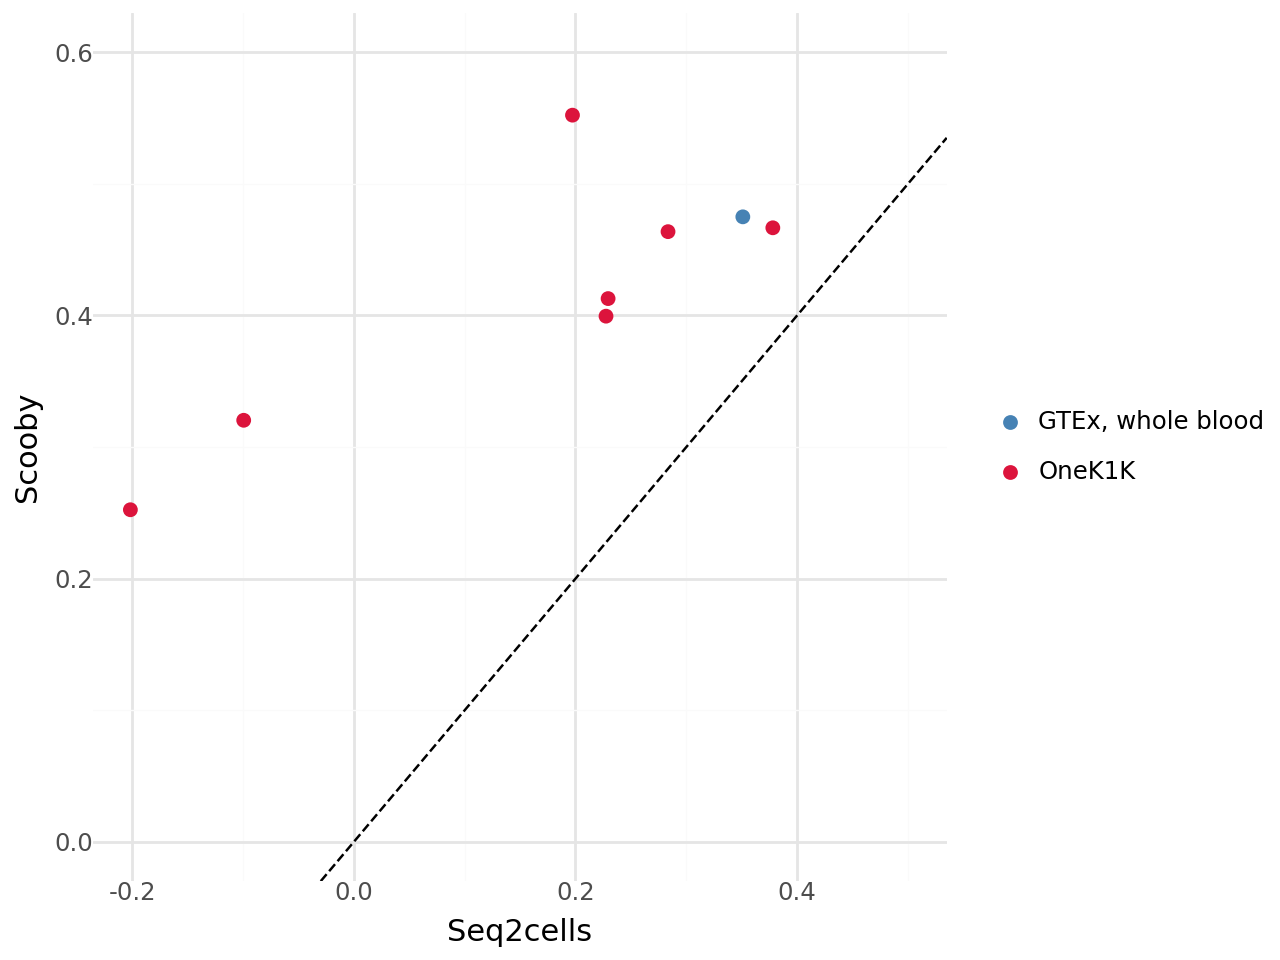

In [85]:
import plotnine as p9
p =(p9.ggplot(data=all_corrs_scooby.reset_index(), mapping=p9.aes(x='seq2cells',y='scooby_neurips', color='Study')) 
 + p9.geom_point(size=2) 
 + p9.geom_abline(linetype='dashed')
 + p9.theme_minimal()
 + p9.scale_color_manual(['steelblue', 'crimson'])
 + p9.labs(x='Seq2cells', y='Scooby')
 + p9.coord_cartesian(xlim=(-.2,0.5), ylim=(0,0.6))
 + p9.theme(legend_title=p9.element_blank())
)

# p.save("../../figures/figures/Revisions/seq2cells_borzoi_eqtl_perf.png", dpi = 300)
p

In [86]:
all_corrs_scooby

model                             scooby_neurips  seq2cells
Study             tissue                                   
GTEx, whole blood blood                 0.474967   0.351031
OneK1K            B cell                0.552220   0.197322
                  CD16+ monocyte        0.814286   0.478571
                  CD4+ T cell           0.399487   0.227584
                  CD4+ TCM cell         0.463709   0.283532
                  CD4+ TEM cell         0.110714  -0.325000
                  CD8+ T cell           0.320381  -0.099340
                  CD8+ TEM cell         0.412850   0.229464
                  NK cell               0.466638   0.378097
                  Treg memory           0.208791  -0.375824
                  memory B cell         0.252400  -0.201581
                  monocyte              0.754386   0.168421

In [89]:
scipy.stats.wilcoxon(all_corrs_scooby['scooby_neurips'], all_corrs_scooby['seq2cells'])

WilcoxonResult(statistic=0.0, pvalue=0.00048828125)

## Plot one example and sign concordance

In [90]:
def make_scooby_mapping(adata):
    mapping = dict()
    mapping['GTEx'] = {
        'blood' : set(susie_df.query('study_label == "OneK1K"').tissue_label.str.replace(' ', '_')),
    }
    mapping['OneK1K'] = dict()
    for ct in set(susie_df.query('study_label == "OneK1K"').tissue_label.unique()):
        mapping['OneK1K'][ct] = [ct.replace(" ", "_")]
    
    return mapping
    
mapping = make_scooby_mapping(adata)
rows = []
study = 'GTEx'
tissue = 'blood'

tissue_mapping = mapping[study]
reduced_susie = susie_df.query('study_label == @study and tissue_label == @tissue').sort_values('sample_size',ascending=False).drop_duplicates(subset=['gene_id','variant'], keep='first')
assert len(reduced_susie) > 0
reduced_adata = adata[adata.obs.index.isin(set(reduced_susie['unique_id'])), adata.var.index.isin(tissue_mapping[tissue])]
snp_effects = pd.DataFrame({'variant':reduced_adata.obs['variant'],
                            'gene_id':reduced_adata.obs['gene_id'],
                            'pred_effect':reduced_adata.X.mean(axis=1)})
snp_effects['abs_pred_effect'] = np.abs(snp_effects['pred_effect'])

reduced_susie = reduced_susie.merge(snp_effects, on=['variant','gene_id'])
assert len(reduced_susie) == len(snp_effects)

corr = scipy.stats.spearmanr(reduced_susie['beta'],reduced_susie['pred_effect'])[0]
corr

0.4493354338649274

In [91]:
reduced_adata.X.shape

(908, 21)

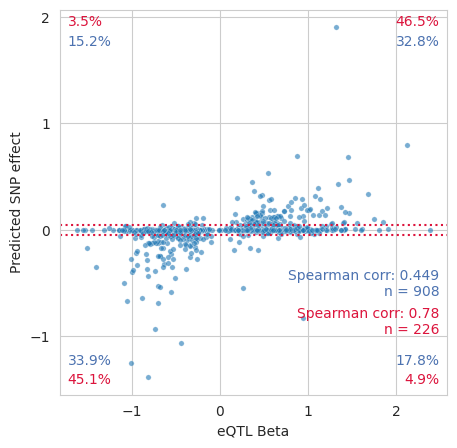

In [92]:
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=reduced_susie, y='pred_effect', x='beta',  alpha=0.6, s = 15, ax=ax)
ax.set_xlabel('eQTL Beta')
ax.set_ylabel('Predicted SNP effect')

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.yaxis.set_major_locator(MultipleLocator(1.0))


# ax.set_ylim((-3,2))
# corr.update({ct: scipy.stats.spearmanr(sns_df['eSNP'], sns_df['beta_posterior'])[0]})
quadrant_1 = sum(np.logical_and(reduced_susie['pred_effect'] < 0, reduced_susie['beta'] < 0))/len(reduced_susie)
quadrant_2 = sum(np.logical_and(reduced_susie['pred_effect'] > 0, reduced_susie['beta'] < 0))/len(reduced_susie)
quadrant_3 = sum(np.logical_and(reduced_susie['pred_effect'] < 0, reduced_susie['beta'] > 0))/len(reduced_susie)
quadrant_4 = sum(np.logical_and(reduced_susie['pred_effect'] > 0, reduced_susie['beta'] > 0))/len(reduced_susie)
fig.text(0.02, 0.07, f"{(quadrant_1 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')
fig.text(0.02, 0.90, f"{(quadrant_2 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')
fig.text(0.98, 0.07, f"{(quadrant_3 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')
fig.text(0.98, 0.90, f"{(quadrant_4 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')


quadrant_1 = sum(np.logical_and(reduced_susie['pred_effect'] < -0.05, reduced_susie['beta'] < -0.05))/len(reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)])
quadrant_2 = sum(np.logical_and(reduced_susie['pred_effect'] > 0.05, reduced_susie['beta'] < -0.05))/len(reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)])
quadrant_3 = sum(np.logical_and(reduced_susie['pred_effect'] < -0.05, reduced_susie['beta'] > 0.05))/len(reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)])
quadrant_4 = sum(np.logical_and(reduced_susie['pred_effect'] > 0.05, reduced_susie['beta'] > 0.05))/len(reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)])
fig.text(0.02, 0.02, f"{(quadrant_1 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = 'crimson')
fig.text(0.02, 0.95, f"{(quadrant_2 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = 'crimson')
fig.text(0.98, 0.02, f"{(quadrant_3 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = 'crimson')
fig.text(0.98, 0.95, f"{(quadrant_4 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = 'crimson')

# ax.axvline(0.05, linestyle = ':', color ='r')
# ax.axvline(-0.05, linestyle = ':', color ='r')
ax.axhline(0.05, linestyle = ':', color ='crimson')
ax.axhline(-0.05, linestyle = ':', color ='crimson')
red_corr = scipy.stats.spearmanr(reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)]['pred_effect'], reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)]['beta'])[0]
fig.text(0.98, 0.25, f"Spearman corr: {np.round(corr,3)}\nn = {len(reduced_susie)}", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')

fig.text(0.98, 0.15, f"Spearman corr: {np.round(red_corr,3)}\nn = {len(reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)])}", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = 'crimson')
ax.grid(which='minor', color='w', linewidth=1.0)
# fig.savefig("../../figures/figures/Revisions/scooby_concordance.png", dpi = 300, bbox_inches ='tight')

plt.show()

In [93]:
edges = [0, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 150000, 262144]
new_edges = edges
reduced_susie['distance_bin']  = pd.cut(reduced_susie['abs_dist_to_tss'], bins = new_edges,include_lowest=True, precision = 0)
reduced_susie['Set'] = reduced_susie['pred_effect'].apply(lambda x : 'Pred. abs. effect > 3.5%' if np.abs(x) > 0.05 else 'No filtering')

In [94]:
def get_in_vs_out(x):
    all_len = len(x)
    x = x[x['pred_effect'].abs() > 0.05]
    quadrant_1 = sum(np.logical_and(x['pred_effect'] < 0, x['beta'] < 0))/all_len
    quadrant_4 = sum(np.logical_and(x['pred_effect'] > 0, x['beta'] > 0))/all_len
    all_len = quadrant_1 + quadrant_4
    return all_len

In [95]:
def get_in_numbers(x):
    all_len = len(x)
    x = x[x['pred_effect'].abs() > 0.05]
    quadrant_1 = sum(np.logical_and(x['pred_effect'] < 0, x['beta'] < 0))
    quadrant_4 = sum(np.logical_and(x['pred_effect'] > 0, x['beta'] > 0))
    all_len = quadrant_1 + quadrant_4
    return all_len

In [96]:
distance_to_tss_df = reduced_susie.groupby('distance_bin').apply(lambda x : get_in_vs_out(x)).to_frame()
distance_to_tss_df['Set'] = 'No filtering'
distance_to_tss_df_subset  = reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)].groupby('distance_bin').apply(lambda x : get_in_vs_out(x)).to_frame()
distance_to_tss_df_subset['Set'] = 'Pred. abs. effect > 3.5%'

In [97]:
get_in_vs_out(reduced_susie)

0.22797356828193832

In [98]:

from itertools import chain
ns_all = reduced_susie.groupby(reduced_susie.distance_bin).count()['abs_dist_to_tss'].values
ns_subset = reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)].groupby('distance_bin').count()['abs_dist_to_tss'].values
ns = list(chain.from_iterable(zip(ns_all, ns_subset)))

In [99]:
distance_to_tss_df = pd.concat([distance_to_tss_df,distance_to_tss_df_subset])


In [100]:
binom_test_df = reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)].groupby('distance_bin').apply(lambda x : get_in_numbers(x)).to_frame()
binom_test_df['total'] = ns[1::2]
binom_test_df = binom_test_df.rename({0 : "correct"}, axis=1)
binom_test_df['sig'] = binom_test_df.apply(lambda x : scipy.stats.binomtest(x['correct'], x['total']).pvalue < 0.05, axis =1)
binom_test_df

,correct,total,sig
distance_bin,,,
"(-1, 1000]",105,113,True
"(1000, 2000]",26,27,True
"(2000, 5000]",19,22,True
"(5000, 10000]",15,16,True
"(10000, 20000]",22,23,True
"(20000, 50000]",12,15,True
"(50000, 100000]",5,7,False
"(100000, 150000]",2,2,False
"(150000, 262144]",1,1,False


/scratch/tmp/hingerl/ipykernel_1559503/102570446.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/scratch/tmp/hingerl/ipykernel_1559503/102570446.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


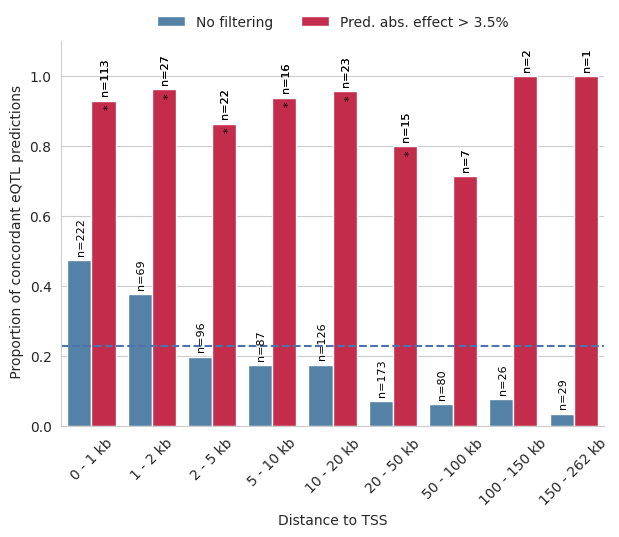

In [101]:
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(distance_to_tss_df, x = 'distance_bin', y = 0, hue = 'Set',  palette = ['steelblue', 'crimson'], ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="center")
labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = []
for i,l in enumerate(labels):
    stripped = l.strip('(').strip(')').strip('[').strip(']').split(',')
    new_labels.append(" - ".join([str(int(s)//1000) for s in stripped]) + f" kb")
for i,(index, row) in enumerate(distance_to_tss_df.sort_index().iterrows()):
    if (i %2 == 0):
        ax.text(ax.get_xticks()[i//2]-0.18, row[0]+ 0.02, f"n={ns[i]}", color='black', ha="center", rotation = 90, fontsize = 8)
    else:
        ax.text(ax.get_xticks()[i//2]+0.22, row[0]+ 0.02, f"n={ns[i]}", color='black', ha="center", rotation = 90, fontsize = 8)
        if binom_test_df.iloc[i//2].sig:
            ax.text(ax.get_xticks()[i//2]+0.28, row[0]- 0.02, "*", color='black', ha="center", rotation = 90, fontsize = 8)    
        ax.text(ax.get_xticks()[i//2]+0.22, row[0]+ 0.02, f"n={ns[i]}", color='black', ha="center", rotation = 90, fontsize = 8)
new_labels[0] = f"0 - 1 kb"
ax.set_xticklabels(new_labels)
ax.legend( loc='upper center', ncols=2, frameon = False, bbox_to_anchor= (.5,1.1))
# sns.move_legend(location ='upper')#bbox_to_anchor=(0.5, 1.1))
ax.axhline(get_in_vs_out(reduced_susie), linestyle = '--', color = '#4c72b0')
ax.set_ylim(0,1.1)
ax.set_xlabel("Distance to TSS")
ax.set_ylabel(" Proportion of concordant eQTL predictions")
sns.despine()
plt.show()
# fig.savefig("../../figures/figures/Revisions/distance_to_TSS_perf_scooby.png", dpi = 300, bbox_inches ='tight')

## Sign concordance seq2cells

In [102]:
model = 'scooby_neurips'
adata_list = []

paths = sorted(glob.glob(f'/s/project/QNA/scborzoi/submission_data/eQTL_preds/Results/Susie/Chunky/scooby_variants_tsscentred/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
for path in tqdm.tqdm(paths):
    adata = ad.read_h5ad(path)
    adata_list.append(adata)

100%|██████████| 11/11 [00:00<00:00, 25.84it/s]


In [103]:
adata = ad.concat(adata_list, merge='same')
adata.obs_names = adata.obs['variant'] + "_" + adata.obs['gene_id']

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [104]:
seq2cells_onek1k = pd.read_csv("seq2cells_onek1k.csv")
seq2cells_gtex = pd.read_csv("seq2cells_gtex.csv")
seq2cells = pd.concat([seq2cells_onek1k, seq2cells_gtex])

In [105]:
susie_df.query('study_label == @study and tissue_label == @tissue').sort_values('sample_size',ascending=False).drop_duplicates(subset=['gene_id','variant'], keep='first').merge(seq2cells, right_on = ['var_id', 'var_linked_gene', 'study_label', 'tissue_label'], left_on = ['variant', 'gene_id','study_label', 'tissue_label'], suffixes=['', '_seq2cells'])[['variant', 'gene_id','study_label', 'tissue_label']].drop_duplicates(subset=['gene_id','variant'], keep='first')

,variant,gene_id,study_label,tissue_label
0,chrX_7927298_G_A,ENSG00000006757,GTEx,blood
1,chr1_20508117_C_A,ENSG00000090432,GTEx,blood
2,chr11_44066439_G_T,ENSG00000110455,GTEx,blood
3,chr12_47759262_G_A,ENSG00000079337,GTEx,blood
4,chr12_7924992_T_G,ENSG00000173262,GTEx,blood
...,...,...,...,...
616,chr8_23225458_G_T,ENSG00000104689,GTEx,blood
617,chr1_37999643_G_A,ENSG00000183386,GTEx,blood
618,chr10_93700616_T_G,ENSG00000148690,GTEx,blood
619,chr11_1941470_C_T,ENSG00000214026,GTEx,blood


In [106]:
def make_scooby_mapping(adata):
    mapping = dict()
    mapping['GTEx'] = {
        'blood' : set(susie_df.query('study_label == "OneK1K"').tissue_label.str.replace(' ', '_')),
    }    
    mapping['OneK1K'] = dict()
    for ct in set(susie_df.query('study_label == "OneK1K"').tissue_label.unique()):
        mapping['OneK1K'][ct] = [ct.replace(" ", "_")]
    return mapping
    
mapping = make_scooby_mapping(adata)
rows = []
for study in ['GTEx']:
    tissue_mapping = mapping[study]
    for tissue in tissue_mapping.keys():
        reduced_susie = susie_df.query('study_label == @study and tissue_label == @tissue').sort_values('sample_size',ascending=False).drop_duplicates(subset=['gene_id','variant'], keep='first').merge(seq2cells, right_on = ['var_id', 'var_linked_gene', 'study_label', 'tissue_label'], left_on = ['variant', 'gene_id','study_label', 'tissue_label'], suffixes=['', '_seq2cells']).drop_duplicates(subset=['gene_id','variant'], keep='first')
        assert len(reduced_susie) > 0
        reduced_adata = adata[adata.obs.index.isin(set(reduced_susie['unique_id'])), adata.var.index.isin(tissue_mapping[tissue])]
        snp_effects = pd.DataFrame({'variant':reduced_adata.obs['variant'],
                                    'gene_id':reduced_adata.obs['gene_id'],
                                    'pred_effect':reduced_adata.X.mean(axis=1)})
        snp_effects['abs_pred_effect'] = np.abs(snp_effects['pred_effect'])
        
        reduced_susie = reduced_susie.merge(snp_effects, on=['variant','gene_id'])
        assert len(reduced_susie) == len(snp_effects)
    
        corr = scipy.stats.spearmanr(reduced_susie['beta'],reduced_susie['pred_effect'])[0]
        corr_seq2cells = scipy.stats.spearmanr(reduced_susie['beta'],reduced_susie['pred_beta'])[0]
        dist_corr = scipy.stats.spearmanr(reduced_susie['abs_dist_to_tss'],reduced_susie['abs_pred_effect'])[0]
        rows.append({'model':model, 'study':study, 'tissue':tissue, 'n':len(snp_effects),
                     'corr':corr, 'dist_corr':dist_corr})
        rows.append({'model':"seq2cells", 'study':study, 'tissue':tissue, 'n':len(snp_effects),
                     'corr':corr_seq2cells})
all_corrs_scooby = pd.DataFrame(rows)

In [107]:
# reduced_susie = reduced_susie[['abs_dist_to_tss', 'pred_beta', 'beta']].rename({"pred_beta" : "pred_effect"}, axis =1)
reduced_susie = reduced_susie[['abs_dist_to_tss', 'pred_effect', 'beta']]

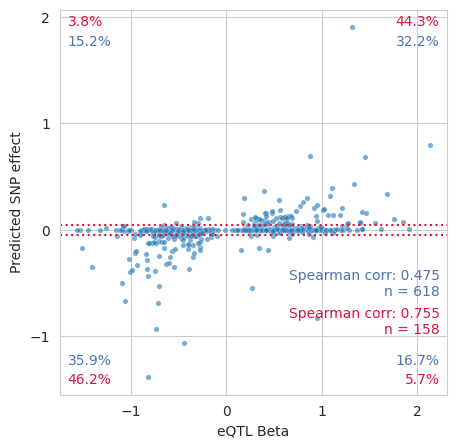

In [108]:
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=reduced_susie, y='pred_effect', x='beta',  alpha=0.6, s = 15, ax=ax)
ax.set_xlabel('eQTL Beta')
ax.set_ylabel('Predicted SNP effect')

cutoff = 0.05

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.yaxis.set_major_locator(MultipleLocator(1.0))


# ax.set_ylim((-3,2))
# corr.update({ct: scipy.stats.spearmanr(sns_df['eSNP'], sns_df['beta_posterior'])[0]})
quadrant_1 = sum(np.logical_and(reduced_susie['pred_effect'] < 0, reduced_susie['beta'] < 0))/len(reduced_susie)
quadrant_2 = sum(np.logical_and(reduced_susie['pred_effect'] > 0, reduced_susie['beta'] < 0))/len(reduced_susie)
quadrant_3 = sum(np.logical_and(reduced_susie['pred_effect'] < 0, reduced_susie['beta'] > 0))/len(reduced_susie)
quadrant_4 = sum(np.logical_and(reduced_susie['pred_effect'] > 0, reduced_susie['beta'] > 0))/len(reduced_susie)
fig.text(0.02, 0.07, f"{(quadrant_1 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')
fig.text(0.02, 0.90, f"{(quadrant_2 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')
fig.text(0.98, 0.07, f"{(quadrant_3 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')
fig.text(0.98, 0.90, f"{(quadrant_4 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')


quadrant_1 = sum(np.logical_and(reduced_susie['pred_effect'] < -cutoff, reduced_susie['beta'] < -cutoff))/len(reduced_susie[(reduced_susie['pred_effect'] > cutoff) | (reduced_susie['pred_effect'] < -cutoff)])
quadrant_2 = sum(np.logical_and(reduced_susie['pred_effect'] > cutoff, reduced_susie['beta'] < -cutoff))/len(reduced_susie[(reduced_susie['pred_effect'] > cutoff) | (reduced_susie['pred_effect'] < -cutoff)])
quadrant_3 = sum(np.logical_and(reduced_susie['pred_effect'] < -cutoff, reduced_susie['beta'] > cutoff))/len(reduced_susie[(reduced_susie['pred_effect'] > cutoff) | (reduced_susie['pred_effect'] < -cutoff)])
quadrant_4 = sum(np.logical_and(reduced_susie['pred_effect'] > cutoff, reduced_susie['beta'] > cutoff))/len(reduced_susie[(reduced_susie['pred_effect'] > cutoff) | (reduced_susie['pred_effect'] < -cutoff)])
fig.text(0.02, 0.02, f"{(quadrant_1 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = 'crimson')
fig.text(0.02, 0.95, f"{(quadrant_2 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = 'crimson')
fig.text(0.98, 0.02, f"{(quadrant_3 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = 'crimson')
fig.text(0.98, 0.95, f"{(quadrant_4 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = 'crimson')

# ax.axvline(cutoff, linestyle = ':', color ='r')
# ax.axvline(-cutoff, linestyle = ':', color ='r')
ax.axhline(cutoff, linestyle = ':', color ='crimson')
ax.axhline(-cutoff, linestyle = ':', color ='crimson')
red_corr = scipy.stats.spearmanr(reduced_susie[(reduced_susie['pred_effect'] > cutoff) | (reduced_susie['pred_effect'] < -cutoff)]['pred_effect'], reduced_susie[(reduced_susie['pred_effect'] > cutoff) | (reduced_susie['pred_effect'] < -cutoff)]['beta'])[0]
fig.text(0.98, 0.25, f"Spearman corr: {np.round(corr,3)}\nn = {len(reduced_susie)}", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')

fig.text(0.98, 0.15, f"Spearman corr: {np.round(red_corr,3)}\nn = {len(reduced_susie[(reduced_susie['pred_effect'] > cutoff) | (reduced_susie['pred_effect'] < -cutoff)])}", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = 'crimson')
ax.grid(which='minor', color='w', linewidth=1.0)
# fig.savefig("../../figures/figures/Revisions/seq2cells_concordance.svg", dpi = 300, bbox_inches ='tight')

plt.show()

In [109]:
edges = [0, 1000, 2000, 5000, 10000, 20000, 50000]
new_edges = edges
reduced_susie['distance_bin']  = pd.cut(reduced_susie['abs_dist_to_tss'], bins = new_edges,include_lowest=True, precision = 0)
reduced_susie['Set'] = reduced_susie['pred_effect'].apply(lambda x : 'Pred. abs. effect > 3.5%' if np.abs(x) > 0.05 else 'No filtering')

In [110]:
def get_in_vs_out(x):
    all_len = len(x)
    x = x[x['pred_effect'].abs() > cutoff]
    quadrant_1 = sum(np.logical_and(x['pred_effect'] < 0, x['beta'] < 0))/all_len
    quadrant_4 = sum(np.logical_and(x['pred_effect'] > 0, x['beta'] > 0))/all_len
    all_len = quadrant_1 + quadrant_4
    return all_len

In [111]:
def get_in_numbers(x):
    all_len = len(x)
    x = x[x['pred_effect'].abs() > cutoff]
    quadrant_1 = sum(np.logical_and(x['pred_effect'] < 0, x['beta'] < 0))
    quadrant_4 = sum(np.logical_and(x['pred_effect'] > 0, x['beta'] > 0))
    all_len = quadrant_1 + quadrant_4
    return all_len

In [112]:
distance_to_tss_df = reduced_susie.groupby('distance_bin').apply(lambda x : get_in_vs_out(x)).to_frame()
distance_to_tss_df['Set'] = 'No filtering'
distance_to_tss_df_subset  = reduced_susie[(reduced_susie['pred_effect'] > cutoff) | (reduced_susie['pred_effect'] < -cutoff)].groupby('distance_bin').apply(lambda x : get_in_vs_out(x)).to_frame()
distance_to_tss_df_subset['Set'] = 'Pred. abs. effect > 3.5%'

In [113]:
get_in_vs_out(reduced_susie)

0.2313915857605178

In [114]:

from itertools import chain
ns_all = reduced_susie.groupby(reduced_susie.distance_bin).count()['abs_dist_to_tss'].values
ns_subset = reduced_susie[(reduced_susie['pred_effect'] > cutoff) | (reduced_susie['pred_effect'] < -cutoff)].groupby('distance_bin').count()['abs_dist_to_tss'].values
ns = list(chain.from_iterable(zip(ns_all, ns_subset)))

In [115]:
distance_to_tss_df = pd.concat([distance_to_tss_df,distance_to_tss_df_subset])


In [116]:
distance_to_tss_df

,0,Set
distance_bin,,
"(-1, 1000]",0.458599,No filtering
"(1000, 2000]",0.404255,No filtering
"(2000, 5000]",0.191781,No filtering
"(5000, 10000]",0.193548,No filtering
"(10000, 20000]",0.141304,No filtering
"(20000, 50000]",0.071429,No filtering
"(-1, 1000]",0.923077,Pred. abs. effect > 3.5%
"(1000, 2000]",0.950000,Pred. abs. effect > 3.5%
"(2000, 5000]",0.823529,Pred. abs. effect > 3.5%


In [117]:
binom_test_df = reduced_susie[(reduced_susie['pred_effect'] > cutoff) | (reduced_susie['pred_effect'] < -cutoff)].groupby('distance_bin').apply(lambda x : get_in_numbers(x)).to_frame()
binom_test_df['total'] = ns[1::2]
binom_test_df = binom_test_df.rename({0 : "correct"}, axis=1)
binom_test_df['sig'] = binom_test_df.apply(lambda x : scipy.stats.binomtest(x['correct'], x['total']).pvalue < 0.05, axis =1)
binom_test_df

,correct,total,sig
distance_bin,,,
"(-1, 1000]",72,78,True
"(1000, 2000]",19,20,True
"(2000, 5000]",14,17,True
"(5000, 10000]",12,13,True
"(10000, 20000]",13,14,True
"(20000, 50000]",9,12,False


/scratch/tmp/hingerl/ipykernel_1559503/2570560564.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/scratch/tmp/hingerl/ipykernel_1559503/2570560564.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


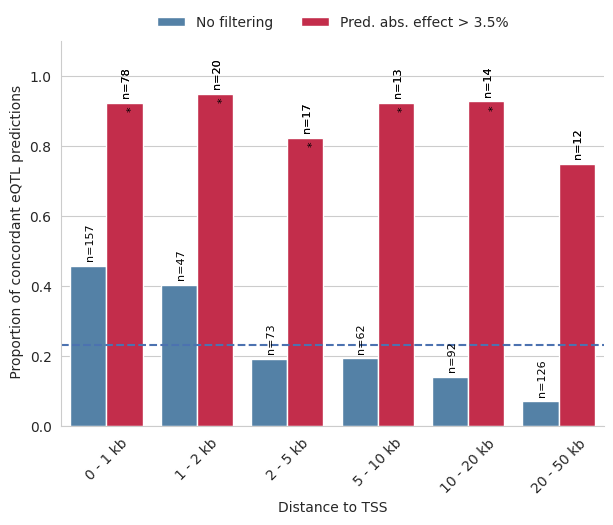

In [118]:
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(distance_to_tss_df, x = 'distance_bin', y = 0, hue = 'Set',  palette = ['steelblue', 'crimson'], ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="center")
labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = []
for i,l in enumerate(labels):
    stripped = l.strip('(').strip(')').strip('[').strip(']').split(',')
    new_labels.append(" - ".join([str(int(s)//1000) for s in stripped]) + f" kb")
for i,(index, row) in enumerate(distance_to_tss_df.sort_index().iterrows()):
    if (i %2 == 0):
        ax.text(ax.get_xticks()[i//2]-0.18, row[0]+ 0.02, f"n={ns[i]}", color='black', ha="center", rotation = 90, fontsize = 8)
    else:
        ax.text(ax.get_xticks()[i//2]+0.22, row[0]+ 0.02, f"n={ns[i]}", color='black', ha="center", rotation = 90, fontsize = 8)
        if binom_test_df.iloc[i//2].sig:
            ax.text(ax.get_xticks()[i//2]+0.28, row[0]- 0.02, "*", color='black', ha="center", rotation = 90, fontsize = 8)    
        ax.text(ax.get_xticks()[i//2]+0.22, row[0]+ 0.02, f"n={ns[i]}", color='black', ha="center", rotation = 90, fontsize = 8)
new_labels[0] = f"0 - 1 kb"
ax.set_xticklabels(new_labels)
ax.legend( loc='upper center', ncols=2, frameon = False, bbox_to_anchor= (.5,1.1))
# sns.move_legend(location ='upper')#bbox_to_anchor=(0.5, 1.1))
ax.axhline(get_in_vs_out(reduced_susie), linestyle = '--', color = '#4c72b0')
ax.set_ylim(0,1.1)
ax.set_xlabel("Distance to TSS")
ax.set_ylabel(" Proportion of concordant eQTL predictions")
sns.despine()
plt.show()
# fig.savefig("../../figures/figures/Revisions/distance_to_TSS_perf_seq2cells.svg", dpi = 300, bbox_inches ='tight')

In [119]:
reduced_susie

,abs_dist_to_tss,pred_effect,beta,distance_bin,Set
0,442,0.006624,0.634491,"(-1.0, 1000.0]",No filtering
1,35,0.024884,0.406546,"(-1.0, 1000.0]",No filtering
2,514,0.158802,1.466420,"(-1.0, 1000.0]",Pred. abs. effect > 3.5%
3,11779,-0.074790,0.655472,"(10000.0, 20000.0]",Pred. abs. effect > 3.5%
4,33843,0.008121,1.018810,"(20000.0, 50000.0]",No filtering
...,...,...,...,...,...
613,355,-0.029733,-0.251591,"(-1.0, 1000.0]",No filtering
614,5964,0.172417,0.733264,"(5000.0, 10000.0]",Pred. abs. effect > 3.5%
615,1977,-0.001640,0.603507,"(1000.0, 2000.0]",No filtering
616,5808,-0.001680,-1.107350,"(5000.0, 10000.0]",No filtering


## Plot sign concordance Borzoi

In [120]:
rows = []
df_list = []
rna_mapping = None
cage_mapping = None
for assay_type in ['RNA']:
    for model in ['borzoi_bs1_highpip']:
        for rep in [0]:
            adata_list = []
            autocast = ""
            assay_path = 'tsscentred'
            paths = sorted(glob.glob(f'{data_path}/eQTL_fig4/{model}_tsscentred_keepscale_{autocast}{rep}/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
            for path in paths:
                adata = ad.read_h5ad(path)
                if rna_mapping is None and assay_type == 'RNA':
                    rna_mapping = make_borzoi_mapping(adata)
                    borzoi_mapping = rna_mapping
                mapping = rna_mapping if assay_type == 'RNA' else cage_mapping
                adata_list.append(adata)
            
            adata = ad.concat(adata_list, merge='same')
            adata.obs_names = adata.obs['variant'] + "_" + adata.obs['gene_id']
            
            for study in mapping.keys():
                tissue_mapping = mapping[study]
                for tissue in tissue_mapping.keys():
                    reduced_susie = susie_df.query('study_label == @study and tissue_label == @tissue').sort_values('sample_size',ascending=False).drop_duplicates(subset=['gene_id','variant'], keep='first')
                
                    reduced_adata = adata[adata.obs.index.isin(set(reduced_susie['unique_id'])), adata.var.description.isin(tissue_mapping[tissue])]
                    snp_effects = pd.DataFrame({'variant':reduced_adata.obs['variant'],
                                                'gene_id':reduced_adata.obs['gene_id'],
                                                'pred_effect':reduced_adata.X.mean(axis=1)})
                    snp_effects['abs_pred_effect'] = np.abs(snp_effects['pred_effect'])
                    
                    reduced_susie = reduced_susie.merge(snp_effects, on=['variant','gene_id'])
                    assert len(reduced_susie) == len(snp_effects)
        
                    corr = scipy.stats.spearmanr(reduced_susie['beta'],reduced_susie['pred_effect'])[0]
                    pearson = scipy.stats.pearsonr(reduced_susie['beta'],reduced_susie['pred_effect'])[0]
                    dist_corr = scipy.stats.spearmanr(reduced_susie['abs_dist_to_tss'],reduced_susie['abs_pred_effect'])[0]
                    rows.append({'model':model, 'study':study, 'tissue':tissue, 'n':len(snp_effects),
                                 'rep':rep, 'corr':corr, 'r':pearson, 'dist_corr':dist_corr, 'assay_type':assay_type})
        
                    reduced_susie['model'] = model
                    reduced_susie['rep'] = rep
                    reduced_susie['assay_type'] = assay_type
                    df_list.append(reduced_susie)

all_corrs = pd.DataFrame(rows)
all_vars = pd.concat(df_list)

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [121]:
reduced_susie

,molecular_trait_id,gene_id,cs_id,variant,rsid,cs_size,pip,pvalue,beta,se,...,gene_end,Strand,dist_to_tss,abs_dist_to_tss,unique_id,pred_effect,abs_pred_effect,model,rep,assay_type
0,ENSG00000006757,ENSG00000006757,ENSG00000006757_L1,chrX_7927298_G_A,rs144642014,1,0.997426,2.328190e-08,0.634491,0.112199,...,7927739,-,-442,442,chrX_7927298_G_A_ENSG00000006757,-0.002792,0.002792,borzoi_bs1_highpip,0,RNA
1,ENSG00000090432,ENSG00000090432,ENSG00000090432_L1,chr1_20508117_C_A,rs6700034,1,0.999703,9.612940e-22,0.406546,0.040938,...,20508151,-,-35,35,chr1_20508117_C_A_ENSG00000090432,0.015352,0.015352,borzoi_bs1_highpip,0,RNA
2,ENSG00000110455,ENSG00000110455,ENSG00000110455_L1,chr11_44066439_G_T,rs2074038,1,1.000000,1.244830e-116,1.466420,0.051514,...,44084237,+,514,514,chr11_44066439_G_T_ENSG00000110455,0.205621,0.205621,borzoi_bs1_highpip,0,RNA
3,ENSG00000079337,ENSG00000079337,ENSG00000079337_L1,chr12_47759262_G_A,rs12813049,1,1.000000,3.019420e-18,0.655472,0.073051,...,47771040,-,-11779,11779,chr12_47759262_G_A_ENSG00000079337,-0.039430,0.039430,borzoi_bs1_highpip,0,RNA
4,ENSG00000173262,ENSG00000173262,ENSG00000173262_L1,chr12_7924992_T_G,rs79990247,1,1.000000,4.449580e-64,1.018810,0.053818,...,7891148,-,33843,33843,chr12_7924992_T_G_ENSG00000173262,0.001213,0.001213,borzoi_bs1_highpip,0,RNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,ENSG00000183386,ENSG00000183386,ENSG00000183386_L1,chr1_37999643_G_A,rs4634868,1,1.000000,2.198260e-42,0.733264,0.049952,...,38005606,-,-5964,5964,chr1_37999643_G_A_ENSG00000183386,0.106037,0.106037,borzoi_bs1_highpip,0,RNA
904,ENSG00000148690,ENSG00000148690,ENSG00000148690_L1,chr10_93700616_T_G,rs1998840,1,0.990075,3.879210e-27,0.603507,0.053449,...,93702592,-,-1977,1977,chr10_93700616_T_G_ENSG00000148690,0.000043,0.000043,borzoi_bs1_highpip,0,RNA
905,ENSG00000214026,ENSG00000214026,ENSG00000214026_L1,chr11_1941470_C_T,rs1104890,1,1.000000,1.227710e-97,-1.107350,0.044209,...,1984522,+,-5808,5808,chr11_1941470_C_T_ENSG00000214026,-0.000701,0.000701,borzoi_bs1_highpip,0,RNA
906,ENSG00000176834,ENSG00000176834,ENSG00000176834_L1,chr12_118063793_G_A,rs4128858,1,1.000000,4.696490e-53,-0.631302,0.037526,...,118136026,-,-72234,72234,chr12_118063793_G_A_ENSG00000176834,0.004840,0.004840,borzoi_bs1_highpip,0,RNA


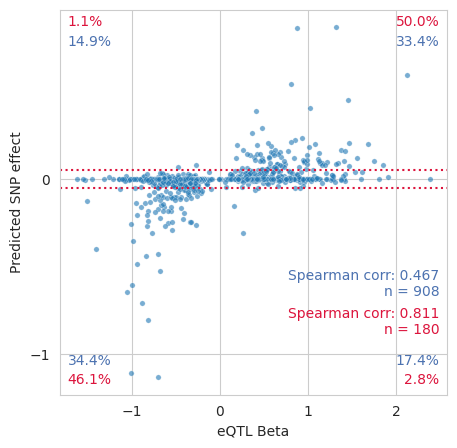

In [122]:
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=reduced_susie, y='pred_effect', x='beta',  alpha=0.6, s = 15, ax=ax)
ax.set_xlabel('eQTL Beta')
ax.set_ylabel('Predicted SNP effect')

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.yaxis.set_major_locator(MultipleLocator(1.0))


# ax.set_ylim((-3,2))
# corr.update({ct: scipy.stats.spearmanr(sns_df['eSNP'], sns_df['beta_posterior'])[0]})
quadrant_1 = sum(np.logical_and(reduced_susie['pred_effect'] < 0, reduced_susie['beta'] < 0))/len(reduced_susie)
quadrant_2 = sum(np.logical_and(reduced_susie['pred_effect'] > 0, reduced_susie['beta'] < 0))/len(reduced_susie)
quadrant_3 = sum(np.logical_and(reduced_susie['pred_effect'] < 0, reduced_susie['beta'] > 0))/len(reduced_susie)
quadrant_4 = sum(np.logical_and(reduced_susie['pred_effect'] > 0, reduced_susie['beta'] > 0))/len(reduced_susie)
fig.text(0.02, 0.07, f"{(quadrant_1 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')
fig.text(0.02, 0.90, f"{(quadrant_2 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')
fig.text(0.98, 0.07, f"{(quadrant_3 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')
fig.text(0.98, 0.90, f"{(quadrant_4 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')


quadrant_1 = sum(np.logical_and(reduced_susie['pred_effect'] < -0.05, reduced_susie['beta'] < -0.05))/len(reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)])
quadrant_2 = sum(np.logical_and(reduced_susie['pred_effect'] > 0.05, reduced_susie['beta'] < -0.05))/len(reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)])
quadrant_3 = sum(np.logical_and(reduced_susie['pred_effect'] < -0.05, reduced_susie['beta'] > 0.05))/len(reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)])
quadrant_4 = sum(np.logical_and(reduced_susie['pred_effect'] > 0.05, reduced_susie['beta'] > 0.05))/len(reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)])
fig.text(0.02, 0.02, f"{(quadrant_1 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = 'crimson')
fig.text(0.02, 0.95, f"{(quadrant_2 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = 'crimson')
fig.text(0.98, 0.02, f"{(quadrant_3 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = 'crimson')
fig.text(0.98, 0.95, f"{(quadrant_4 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = 'crimson')

# ax.axvline(0.05, linestyle = ':', color ='r')
# ax.axvline(-0.05, linestyle = ':', color ='r')
ax.axhline(0.05, linestyle = ':', color ='crimson')
ax.axhline(-0.05, linestyle = ':', color ='crimson')
red_corr = scipy.stats.spearmanr(reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)]['pred_effect'], reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)]['beta'])[0]
fig.text(0.98, 0.25, f"Spearman corr: {np.round(corr,3)}\nn = {len(reduced_susie)}", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')

fig.text(0.98, 0.15, f"Spearman corr: {np.round(red_corr,3)}\nn = {len(reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)])}", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = 'crimson')
ax.grid(which='minor', color='w', linewidth=1.0)
# fig.savefig("../../figures/figures/Revisions/borzoi_concordance.svg", dpi = 300, bbox_inches ='tight')

plt.show()

In [123]:
edges = [0, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 150000, 262144]
new_edges = edges
reduced_susie['distance_bin']  = pd.cut(reduced_susie['abs_dist_to_tss'], bins = new_edges,include_lowest=True, precision = 0)
reduced_susie['Set'] = reduced_susie['pred_effect'].apply(lambda x : 'Pred. abs. effect > 3.5%' if np.abs(x) > 0.05 else 'No filtering')

In [124]:
def get_in_vs_out(x):
    all_len = len(x)
    x = x[x['pred_effect'].abs() > 0.05]
    quadrant_1 = sum(np.logical_and(x['pred_effect'] < 0, x['beta'] < 0))/all_len
    quadrant_4 = sum(np.logical_and(x['pred_effect'] > 0, x['beta'] > 0))/all_len
    all_len = quadrant_1 + quadrant_4
    return all_len

In [125]:
def get_in_numbers(x):
    all_len = len(x)
    x = x[x['pred_effect'].abs() > 0.05]
    quadrant_1 = sum(np.logical_and(x['pred_effect'] < 0, x['beta'] < 0))
    quadrant_4 = sum(np.logical_and(x['pred_effect'] > 0, x['beta'] > 0))
    all_len = quadrant_1 + quadrant_4
    return all_len

In [126]:
distance_to_tss_df = reduced_susie.groupby('distance_bin').apply(lambda x : get_in_vs_out(x)).to_frame()
distance_to_tss_df['Set'] = 'No filtering'
distance_to_tss_df_subset  = reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)].groupby('distance_bin').apply(lambda x : get_in_vs_out(x)).to_frame()
distance_to_tss_df_subset['Set'] = 'Pred. abs. effect > 3.5%'

In [127]:
get_in_vs_out(reduced_susie)

0.19052863436123346

In [128]:

from itertools import chain
ns_all = reduced_susie.groupby(reduced_susie.distance_bin).count()['abs_dist_to_tss'].values
ns_subset = reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)].groupby('distance_bin').count()['abs_dist_to_tss'].values
ns = list(chain.from_iterable(zip(ns_all, ns_subset)))

In [129]:
distance_to_tss_df = pd.concat([distance_to_tss_df,distance_to_tss_df_subset])


In [130]:
binom_test_df = reduced_susie[(reduced_susie['pred_effect'] > 0.05) | (reduced_susie['pred_effect'] < -0.05)].groupby('distance_bin').apply(lambda x : get_in_numbers(x)).to_frame()
binom_test_df['total'] = ns[1::2]
binom_test_df = binom_test_df.rename({0 : "correct"}, axis=1)
binom_test_df['sig'] = binom_test_df.apply(lambda x : scipy.stats.binomtest(x['correct'], x['total']).pvalue < 0.05, axis =1)
binom_test_df

,correct,total,sig
distance_bin,,,
"(-1, 1000]",89,91,True
"(1000, 2000]",23,23,True
"(2000, 5000]",12,14,True
"(5000, 10000]",7,7,True
"(10000, 20000]",18,19,True
"(20000, 50000]",15,17,True
"(50000, 100000]",4,4,False
"(100000, 150000]",3,3,False
"(150000, 262144]",2,2,False


/scratch/tmp/hingerl/ipykernel_1559503/3551283591.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/scratch/tmp/hingerl/ipykernel_1559503/3551283591.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


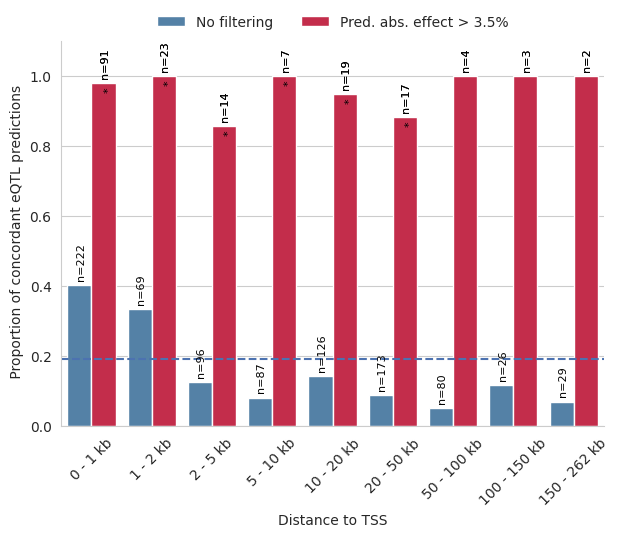

In [131]:
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(distance_to_tss_df, x = 'distance_bin', y = 0, hue = 'Set',  palette = ['steelblue', 'crimson'], ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="center")
labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = []
for i,l in enumerate(labels):
    stripped = l.strip('(').strip(')').strip('[').strip(']').split(',')
    new_labels.append(" - ".join([str(int(s)//1000) for s in stripped]) + f" kb")
for i,(index, row) in enumerate(distance_to_tss_df.sort_index().iterrows()):
    if (i %2 == 0):
        ax.text(ax.get_xticks()[i//2]-0.18, row[0]+ 0.02, f"n={ns[i]}", color='black', ha="center", rotation = 90, fontsize = 8)
    else:
        ax.text(ax.get_xticks()[i//2]+0.22, row[0]+ 0.02, f"n={ns[i]}", color='black', ha="center", rotation = 90, fontsize = 8)
        if binom_test_df.iloc[i//2].sig:
            ax.text(ax.get_xticks()[i//2]+0.28, row[0]- 0.02, "*", color='black', ha="center", rotation = 90, fontsize = 8)    
        ax.text(ax.get_xticks()[i//2]+0.22, row[0]+ 0.02, f"n={ns[i]}", color='black', ha="center", rotation = 90, fontsize = 8)
new_labels[0] = f"0 - 1 kb"
ax.set_xticklabels(new_labels)
ax.legend( loc='upper center', ncols=2, frameon = False, bbox_to_anchor= (.5,1.1))
# sns.move_legend(location ='upper')#bbox_to_anchor=(0.5, 1.1))
ax.axhline(get_in_vs_out(reduced_susie), linestyle = '--', color = '#4c72b0')
ax.set_ylim(0,1.1)
ax.set_xlabel("Distance to TSS")
ax.set_ylabel(" Proportion of concordant eQTL predictions")
sns.despine()
plt.show()
# fig.savefig("../../figures/figures/Revisions/distance_to_TSS_perf_borzoi.svg", dpi = 300, bbox_inches ='tight')

## Calculate var genes and non-var genes

In [132]:
all_onkonk = pd.read_table(f"{data_path}/eQTL_fig4/OneK1K_all_susie.tsv")

In [133]:
all_onkonk['unique_id'] = all_onkonk['variant'] + "_" + all_onkonk['gene_id']

In [134]:
all_onkonk

,molecular_trait_id,gene_id,cs_id,variant,rsid,cs_size,pip,pvalue,beta,se,...,dataset_id,tissue_label,condition_label,sample_size,Chromosome,Pos,Ref,Alt,gene_name,unique_id
0,ENSG00000162631,ENSG00000162631,ENSG00000162631_L1,chr1_107086667_C_T,rs76374975,3,0.498770,1.169090e-07,0.599461,0.112290,...,QTD000606,B cell,naive,977,chr1,107086666,C,T,NTNG1,chr1_107086667_C_T_ENSG00000162631
1,ENSG00000162631,ENSG00000162631,ENSG00000162631_L1,chr1_107135646_G_C,rs115668827,3,0.444216,1.326850e-07,0.583595,0.109805,...,QTD000606,B cell,naive,977,chr1,107135645,G,C,NTNG1,chr1_107135646_G_C_ENSG00000162631
2,ENSG00000156171,ENSG00000156171,ENSG00000156171_L1,chr1_111028458_T_C,rs1282333,14,0.008294,1.768150e-09,-0.296880,0.048858,...,QTD000606,B cell,naive,977,chr1,111028457,T,C,DRAM2,chr1_111028458_T_C_ENSG00000156171
3,ENSG00000156171,ENSG00000156171,ENSG00000156171_L1,chr1_111080935_T_A,rs10857855,14,0.007902,1.910940e-09,0.281159,0.046369,...,QTD000606,B cell,naive,977,chr1,111080934,T,A,DRAM2,chr1_111080935_T_A_ENSG00000156171
4,ENSG00000156171,ENSG00000156171,ENSG00000156171_L1,chr1_111081494_G_C,rs12142849,14,0.007888,1.914970e-09,0.281138,0.046369,...,QTD000606,B cell,naive,977,chr1,111081493,G,C,DRAM2,chr1_111081494_G_C_ENSG00000156171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682933,ENSG00000197958,ENSG00000197958,ENSG00000197958_L1,chr9_127458677_G_A,rs2243784,45,0.015932,3.481100e-25,0.543870,0.050198,...,QTD000629,plasmacytoid dendritic cell,naive,639,chr9,127458676,G,A,RPL12,chr9_127458677_G_A_ENSG00000197958
682934,ENSG00000197958,ENSG00000197958,ENSG00000197958_L1,chr9_127459109_T_C,rs2243767,45,0.015352,3.600200e-25,0.544225,0.050248,...,QTD000629,plasmacytoid dendritic cell,naive,639,chr9,127459108,T,C,RPL12,chr9_127459109_T_C_ENSG00000197958
682935,ENSG00000197958,ENSG00000197958,ENSG00000197958_L1,chr9_127459419_T_A,rs2488899,45,0.016288,3.400790e-25,0.544285,0.050225,...,QTD000629,plasmacytoid dendritic cell,naive,639,chr9,127459418,T,A,RPL12,chr9_127459419_T_A_ENSG00000197958
682936,ENSG00000197958,ENSG00000197958,ENSG00000197958_L1,chr9_127460173_A_G,rs2243663,45,0.016278,3.403890e-25,0.544243,0.050222,...,QTD000629,plasmacytoid dendritic cell,naive,639,chr9,127460172,A,G,RPL12,chr9_127460173_A_G_ENSG00000197958


In [135]:
## compute variant overlap
overlapping_vars = all_onkonk[all_onkonk.unique_id.isin(susie_df.query("study_label=='GTEx' & tissue_label == 'blood'").unique_id)].drop_duplicates('unique_id')

In [136]:
susie_subset = susie_df.query("study_label == 'OneK1K'").drop_duplicates('unique_id')

In [137]:
susie_subset = pd.concat([overlapping_vars, susie_subset]).drop_duplicates('unique_id')

In [138]:
len(susie_subset)

947

In [139]:
gtex_pred = adata_ct[adata_ct.obs_names.isin(susie_subset.unique_id)].copy()

mean_cutoff = 0.0

means = pd.Series(np.abs(gtex_pred.X).mean(axis=1))#ct_differences.query('type == "eSNP"').set_index(['snp_id','Gene']).iloc[:,2:].T.abs().mean(axis=0)  
variances = pd.Series(np.var(gtex_pred.X, axis=1))
quantiles = variances.loc[means[means > mean_cutoff].index].quantile([.15, .85]).values

var_genes = gtex_pred.obs_names#[(variances > quantiles[1]) & (means > mean_cutoff) ].obs_names

# non_var_genes = gtex_pred[(variances < quantiles[0]) & (means > mean_cutoff) ].obs_names

sns_df = pd.DataFrame(gtex_pred[(means >= mean_cutoff) ].X, index=gtex_pred[(means >= mean_cutoff) ].obs_names, columns=gtex_pred.var_names)

In [140]:
var_genes

Index(['chr1_23559582_T_C_ENSG00000197880',
       'chr1_109654510_T_C_ENSG00000168765',
       'chr1_27914572_G_A_ENSG00000117748',
       'chr1_37999643_G_A_ENSG00000183386',
       'chr1_40094786_A_G_ENSG00000131238',
       'chr1_40099836_A_G_ENSG00000131238',
       'chr1_75383333_C_T_ENSG00000137968',
       'chr1_109740350_G_T_ENSG00000134202',
       'chr1_165698544_T_G_ENSG00000143149',
       'chr2_11784824_T_C_ENSG00000134324',
       ...
       'chr22_50445231_G_A_ENSG00000100241',
       'chr22_50526017_A_T_ENSG00000025708',
       'chr22_50625988_T_C_ENSG00000100299',
       'chrX_49238375_G_A_ENSG00000102007',
       'chrX_49305797_G_A_ENSG00000102007', 'chrX_4021806_G_A_ENSG00000285756',
       'chrX_79360717_C_G_ENSG00000078596',
       'chrX_79325402_C_T_ENSG00000078596',
       'chrX_103457292_G_A_ENSG00000133134',
       'chrX_103458846_T_A_ENSG00000133134'],
      dtype='object', length=888)

In [141]:
sns_df

celltype,B_cell,CD16+_monocyte,CD4+_CTL_cell,CD4+_TCM_cell,CD4+_TEM_cell,CD4+_T_cell,CD56+_NK_cell,CD8+_TCM_cell,CD8+_TEM_cell,CD8+_T_cell,...,Treg_memory,dendritic_cell,dnT_cell,gdT_cell,hematopoietic_precursor_cell,memory_B_cell,monocyte,plasmablast,plasmacytoid_dendritic_cell,platelet
chr1_23559582_T_C_ENSG00000197880,-0.001849,-0.001881,-0.003966,0.001882,-0.000219,0.002697,-0.005915,0.000319,-0.004594,0.001674,...,0.001892,-0.003164,-0.000523,-0.003879,-0.003519,-0.002331,-0.000137,-0.006382,-0.003984,-0.005901
chr1_109654510_T_C_ENSG00000168765,0.003493,0.001493,0.003724,0.003644,0.003664,0.003675,0.003434,0.003679,0.003728,0.003701,...,0.003636,0.002615,0.003681,0.003699,0.002838,0.003521,0.001683,0.004256,0.002904,0.003779
chr1_27914572_G_A_ENSG00000117748,0.227999,0.223511,0.191671,0.211400,0.206174,0.213733,0.187515,0.206159,0.190787,0.210135,...,0.211687,0.198618,0.198395,0.192159,0.189541,0.223052,0.221576,0.174530,0.186344,0.166277
chr1_37999643_G_A_ENSG00000183386,0.171634,0.157091,0.185700,0.193243,0.191645,0.193368,0.173165,0.190835,0.185666,0.191841,...,0.191961,0.143542,0.185314,0.185530,0.138390,0.168133,0.145217,0.145118,0.138148,0.161842
chr1_40094786_A_G_ENSG00000131238,0.009143,0.041917,-0.002519,-0.002693,-0.002990,-0.004789,0.003673,-0.003396,-0.002693,-0.005069,...,-0.002254,0.024181,-0.003243,-0.002239,0.018911,0.009032,0.041569,-0.002559,0.018305,-0.004501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX_4021806_G_A_ENSG00000285756,-0.001202,-0.001080,-0.000932,-0.000761,-0.000819,-0.000737,-0.001085,-0.000809,-0.000954,-0.000768,...,-0.000766,-0.001044,-0.000771,-0.000941,-0.001061,-0.001206,-0.000906,-0.001211,-0.001037,-0.000932
chrX_79360717_C_G_ENSG00000078596,-0.002302,0.005629,-0.000530,-0.004510,-0.003413,-0.005504,0.001983,-0.003820,-0.000097,-0.005059,...,-0.004555,0.001355,-0.003213,-0.000396,-0.000077,-0.002007,0.003847,-0.002168,0.000453,-0.000224
chrX_79325402_C_T_ENSG00000078596,0.011802,0.008619,0.012408,0.014798,0.014149,0.014781,0.008749,0.014174,0.012176,0.014335,...,0.014771,0.008694,0.013883,0.012143,0.008106,0.011758,0.008178,0.009039,0.007937,0.008892
chrX_103457292_G_A_ENSG00000133134,0.000317,0.000209,0.000369,0.000451,0.000420,0.000453,0.000295,0.000426,0.000355,0.000438,...,0.000446,0.000312,0.000432,0.000366,0.000358,0.000334,0.000179,0.000462,0.000351,0.000366


In [142]:
key_celltypes = sns_df.columns.tolist()#[key.replace(" ", "_") for key in borzoi_mapping['OneK1K'].keys() ]#if key in corrs_compare.query('n_borzoi>10')['tissue'].tolist()]
sns_df = sns_df.loc[:,  key_celltypes] #subset to borzoi mappable

## Plot curves - subset

In [143]:
rank_df = pd.concat([
    pd.read_csv(f"{data_path}eQTL_fig4/rank_plot_scooby.csv"),
    pd.read_csv(f"{data_path}eQTL_fig4/rank_plot_expr.csv"),
    pd.read_csv(f"{data_path}eQTL_fig4/rank_plot_atac.csv"),
    pd.read_csv(f"{data_path}eQTL_fig4/rank_plot_borzoi.csv")
    ]
)
rank_df['Model'] = (["Scooby"] * 22 + ["Target gene expression"] * 22 + ["ATAC peaks"] * 22 + ["Borzoi, track matched"] * 22)
rank_df['Rank'] = (np.arange(22).tolist()*4)
rank_df['Rank'] = rank_df['Rank'] + 1
rank_df['Negatives'] = rank_df['Total'] - rank_df['Positives']

In [144]:
from scipy.stats import fisher_exact
signif_against_expr = []
for rank in range(1,23):
    tmp_df = rank_df.query("Rank == @rank")
    res  = np.vstack([tmp_df.query('Model == "Target gene expression"')[["Positives", "Negatives"]].values, tmp_df.query('Model == "Scooby"')[["Positives", "Negatives"]].values]).T[::-1]
    print (fisher_exact(res, alternative='two-sided'))
    res = fisher_exact(res, alternative='two-sided')[1] < 0.05
    signif_against_expr.append(res)

SignificanceResult(statistic=1.7974481658692185, pvalue=0.042981619074612)
SignificanceResult(statistic=1.5904024182883054, pvalue=0.02103181913028363)
SignificanceResult(statistic=1.4997917534360683, pvalue=0.013767502742668641)
SignificanceResult(statistic=1.3896072272140647, pvalue=0.026411189596434986)
SignificanceResult(statistic=1.117775812834302, pvalue=0.43242493115851705)
SignificanceResult(statistic=1.0207919600409219, pvalue=0.9029344861513355)
SignificanceResult(statistic=0.9837589486056203, pvalue=0.9077336729631289)
SignificanceResult(statistic=0.9781977269714245, pvalue=0.8686290373576488)
SignificanceResult(statistic=0.9739937723445969, pvalue=0.8343611110838626)
SignificanceResult(statistic=1.0102765474069595, pvalue=0.9198869975071835)
SignificanceResult(statistic=0.9993218425228835, pvalue=1.0)
SignificanceResult(statistic=1.0112218003127094, pvalue=0.9250305420445257)
SignificanceResult(statistic=0.984190029143992, pvalue=0.8905198686365066)
SignificanceResult(stati

In [145]:
rank_df.query("Model == 'Scooby'")['Precision']

0     0.392000
1     0.368000
2     0.346667
3     0.298000
4     0.259200
5     0.236000
6     0.216000
7     0.206000
8     0.202667
9     0.197600
10    0.190545
11    0.186000
12    0.177231
13    0.170286
14    0.163733
15    0.157500
16    0.151059
17    0.147111
18    0.142737
19    0.137600
20    0.133333
21    0.130909
Name: Precision, dtype: float64

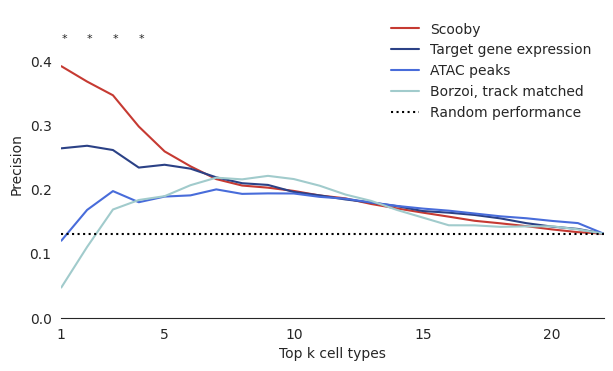

In [146]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(7,4))
sns.lineplot(rank_df, x = 'Rank', y = 'Precision', hue = 'Model',palette=["#c63a32", "#2b4186","#486cda","#a1cbcc"], ax=ax)
# for i, model in enumerate(rank_df.Model.unique()[::-1]):
    # temp_df = rank_df.query("Model == @model")
    # ax.fill_between(temp_df['Rank'], temp_df['CI lower'], temp_df['CI higher'], color=["#c63a32", "#2b4186","#486cda","#a1cbcc"  ][::-1][i], alpha=.10)
for i in range (1,5):
    ax.text(i, 0.43, "*", fontsize = 8)#rank_df.query("Model == 'Scooby' and Rank == @i")['Precision'].iloc[0] + 0.02, "*", )
sns.despine(left=True)
ax.legend(frameon=False, title = "")
handles, _ = ax.get_legend_handles_labels()
ax.set_xlabel("Top k cell types")
ax.set_ylabel("Precision")
new_ticks = ax.get_xticks()
new_ticks[1] =1
ax.set_xticks(new_ticks[1:-1])
ax.set_xlim(1,22)
ax.set_ylim(0,0.48)

plt.legend(handles = handles + [ax.axhline(rank_df.iloc[-1]['Precision'], linestyle = ':', color ='black')], labels = ["Scooby", "Target gene expression", "ATAC peaks", "Borzoi, track matched", "Random performance"],frameon=False,)

# ax.legend(("Scooby", "Target gene expression", "ATAC peaks", "Borzoi, track matched", "Random performance"))

# plt.savefig("../../figures/figures/Revisions/ct_specificity_benchmark_rank_plot.png", dpi = 300, bbox_inches ='tight')
plt.show()